In [1]:
import math
import os
import random
import shutil
import pickle
import matplotlib.colors
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
import tensorflow as tf
import shap
import sys

from simple_colors import *
from scipy.stats import ttest_ind
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer

SEED_VALUE = 11
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)
warnings.filterwarnings('ignore')
os.chdir(os.getcwd())

from analysis.dataset_composition import Dataset_composition
from analysis.corrects_distribution import Corrects_distribution
from analysis.sentiment_accuracy import Sentiment_accuracy
from analysis.mask_accuracy import Mask_accuracy
from analysis.contrast_accuracy import Contrast_accuracy
from analysis.lime_explanation_accuracy import Lime_explanation_accuracy
from analysis.percy_score import calculate_percy
from analysis.rule_mask_accuracy import calculate_rule_mask_accuracy

In [2]:
SUBSET = "one_rule"

In [3]:
##### Sentiment classifiers #####

#vanilla classifiers
base_models = ["rnn_model", 
               "birnn_model_256_hidden_units", 
               "gru_model", 
               "bigru_model", 
               "lstm_model", 
               "bilstm_model"]

#baseline classifiers
cwe = ["rnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER", 
       "birnn_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER",
       "gru_model-ELMO", 
       "bigru_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER", 
       "lstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER",        
       "bilstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"]
ikd = ["rnn_model-IKD-PAD_MASK_ZERO", 
       "birnn_model-IKD-PAD_MASK_ZERO",        
       "gru_model-IKD-PAD_MASK_ZERO",
       "bigru_model-IKD-PAD_MASK_ZERO", 
       "lstm_model-IKD-PAD_MASK_ZERO", 
       "bilstm_model-IKD-PAD_MASK_ZERO"]


#RMM configurations
mask_models = []
masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]    
for mask in masks:
    # models = ["rnn_"+mask+"_mask_model-128-testing_reproducibility", 
    #           "birnn_"+mask+"_mask_model-128-testing_reproducibility", 
    #           "gru_"+mask+"_mask_model-128-testing_reproducibility", 
    #           "bigru_"+mask+"_mask_model-128-testing_reproducibility", 
    #           "lstm_"+mask+"_mask_model-128-testing_reproducibility", 
    #           "bilstm_"+mask+"_mask_model-128-testing_reproducibility"]
    models = ["rnn_"+mask+"_mask_model", 
              "birnn_"+mask+"_mask_model", 
              "gru_"+mask+"_mask_model", 
              "bigru_"+mask+"_mask_model", 
              "lstm_"+mask+"_mask_model", 
              "bilstm_"+mask+"_mask_model"]
    mask_models.append(models)
for index_1, mask_model in enumerate(mask_models):
    for index_2, model in enumerate(mask_model):
        if model == "birnn_rnn_mask_model":
            mask_models[index_1][index_2] = "birnn_rnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_birnn_mask_model":
            mask_models[index_1][index_2] = "birnn_birnn_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_gru_mask_model":
            mask_models[index_1][index_2] = "birnn_gru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bigru_mask_model":
            mask_models[index_1][index_2] = "birnn_bigru_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_lstm_mask_model":
            mask_models[index_1][index_2] = "birnn_lstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bilstm_mask_model":
            mask_models[index_1][index_2] = "birnn_bilstm_mask_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "gru_gru_mask_model":
            mask_models[index_1][index_2] = "gru_gru_mask_model-3"
        if model == "lstm_bigru_mask_model":
            mask_models[index_1][index_2] = "lstm_bigru_mask_model-2"
        if model == "bigru_gru_mask_model":
            mask_models[index_1][index_2] = "bigru_gru_mask_model-2"
        if model == "lstm_gru_mask_model":
            mask_models[index_1][index_2] = "lstm_gru_mask_model-2"
        if model == "bilstm_gru_mask_model":
            mask_models[index_1][index_2] = "bilstm_gru_mask_model-2"
#         if model == "lstm_bilstm_mask_model-128-testing_reproducibility":
#             mask_models[index_1][index_2] = "lstm_bilstm_mask_model-128_hidden_units-trained_on_PC"


#CDRM configurations
mask_contrast_models = []
contrasts = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
for contrast in contrasts:
    masks = ["rnn", "birnn", "gru", "bigru", "lstm", "bilstm"]
    for mask in masks:
        if contrast == mask:
            models = ["rnn_"+mask+"_mask_"+contrast+"_contrast_model", 
                      "birnn_"+mask+"_mask_"+contrast+"_contrast_model", 
                      "gru_"+mask+"_mask_"+contrast+"_contrast_model", 
                      "bigru_"+mask+"_mask_"+contrast+"_contrast_model", 
                      "lstm_"+mask+"_mask_"+contrast+"_contrast_model", 
                      "bilstm_"+mask+"_mask_"+contrast+"_contrast_model"]
            # models = ["rnn_"+mask+"_mask_"+contrast+"_contrast_model", 
            #         "birnn_"+mask+"_mask_"+contrast+"_contrast_model", 
            #         "gru_"+mask+"_mask_"+contrast+"_contrast_model-testing_reproducibility", 
            #         "bigru_"+mask+"_mask_"+contrast+"_contrast_model-testing_reproducibility", 
            #         "lstm_"+mask+"_mask_"+contrast+"_contrast_model-testing_reproducibility", 
            #         "bilstm_"+mask+"_mask_"+contrast+"_contrast_model-testing_reproducibility"]
            mask_contrast_models.append(models)
for index_1, mask_contrast_model in enumerate(mask_contrast_models):
    for index_2, model in enumerate(mask_contrast_model):
        if model == "lstm_bigru_mask_bigru_contrast_model":
            mask_contrast_models[index_1][index_2] = "lstm_bigru_mask_bigru_contrast_model-2"
        if model == "bilstm_bigru_mask_bigru_contrast_model":
            mask_contrast_models[index_1][index_2] = "bilstm_bigru_mask_bigru_contrast_model-2"
        if model == "birnn_rnn_mask_rnn_contrast_model":
             mask_contrast_models[index_1][index_2] = "birnn_rnn_mask_rnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_birnn_mask_birnn_contrast_model":
            mask_contrast_models[index_1][index_2] = "birnn_birnn_mask_birnn_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_gru_mask_gru_contrast_model":
            mask_contrast_models[index_1][index_2] = "birnn_gru_mask_gru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bigru_mask_bigru_contrast_model":
            mask_contrast_models[index_1][index_2] = "birnn_bigru_mask_bigru_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_lstm_mask_lstm_contrast_model":
            mask_contrast_models[index_1][index_2] = "birnn_lstm_mask_lstm_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "birnn_bilstm_mask_bilstm_contrast_model":
            mask_contrast_models[index_1][index_2] = "birnn_bilstm_mask_bilstm_contrast_model-256_HIDDEN_UNITS_CLASSIFIER"
        if model == "gru_bigru_mask_bigru_contrast_model":
            mask_contrast_models[index_1][index_2] = "gru_bigru_mask_bigru_contrast_model-2"
        if model == "bigru_bigru_mask_bigru_contrast_model":
            mask_contrast_models[index_1][index_2] = "bigru_bigru_mask_bigru_contrast_model-2"
        # if model == "lstm_bilstm_mask_bilstm_contrast_model":
        #     mask_contrast_models[index_1][index_2] = "lstm_bilstm_mask_bilstm_contrast_model-testing_reproducibility"

In [4]:
##### Sentiment accuracy, PERCY score, Rule-mask accuracy, Rule-mask accuracy old for the SUBSET #####

#DNN models
RNN_accuracy = []
RNN_distributions_accuracy = []
RNN_percy = []
RNN_distributions_percy = []
RNN_rule_mask_accuracy_old_method = []
RNN_distributions_rule_mask_accuracy_old_method = []
RNN_rule_mask_accuracy = []
RNN_distributions_rule_mask_accuracy = []

BiRNN_accuracy = []
BiRNN_distributions_accuracy = []
BiRNN_percy = []
BiRNN_distributions_percy = []
BiRNN_rule_mask_accuracy_old_method = []
BiRNN_distributions_rule_mask_accuracy_old_method = []
BiRNN_rule_mask_accuracy = []
BiRNN_distributions_rule_mask_accuracy = []

GRU_accuracy = []
GRU_distributions_accuracy = []
GRU_percy = []
GRU_distributions_percy = []
GRU_rule_mask_accuracy_old_method = []
GRU_distributions_rule_mask_accuracy_old_method = []
GRU_rule_mask_accuracy = []
GRU_distributions_rule_mask_accuracy = []

BiGRU_accuracy = []
BiGRU_distributions_accuracy = []
BiGRU_percy = []
BiGRU_distributions_percy = []
BiGRU_rule_mask_accuracy_old_method = []
BiGRU_distributions_rule_mask_accuracy_old_method = []
BiGRU_rule_mask_accuracy = []
BiGRU_distributions_rule_mask_accuracy = []

LSTM_accuracy = []
LSTM_distributions_accuracy = []
LSTM_percy = []
LSTM_distributions_percy = []
LSTM_rule_mask_accuracy_old_method = []
LSTM_distributions_rule_mask_accuracy_old_method = []
LSTM_rule_mask_accuracy = []
LSTM_distributions_rule_mask_accuracy = []

BiLSTM_accuracy = []
BiLSTM_distributions_accuracy = []
BiLSTM_percy = []
BiLSTM_distributions_percy = []
BiLSTM_rule_mask_accuracy_old_method = []
BiLSTM_distributions_rule_mask_accuracy_old_method = []
BiLSTM_rule_mask_accuracy = []
BiLSTM_distributions_rule_mask_accuracy = []

def calculating_metrics_and_distributions(model, results, results_lime_explanations=None, rule_mask_accuracy=None):
    
    #balancing between contrast and no contrast subsets
    one_rule = pd.concat([results.loc[(results["rule_label"]!=0)&(results["contrast"]==1)], results.loc[(results["rule_label"]!=0)&(results["contrast"]==0)]])
    one_rule = one_rule.reset_index(drop=True)
    one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
    one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
    one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
    one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
    one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
    one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
    results = pd.concat([results.loc[results["rule_label"]==0], one_rule])
    results = results.reset_index(drop=True)
    if isinstance(results_lime_explanations, pd.DataFrame):
        results_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
        results_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
        results_lime_explanations = results_lime_explanations.reset_index(drop=True)
    
    #calculating the distributions
    base_sent_corrects = Corrects_distribution(len(results['sentence'])).model_sentiment_correct_distributions(results)
    if isinstance(results_lime_explanations, pd.DataFrame):
        base_lime_percy = calculate_percy(one_rule, results_lime_explanations)
    if rule_mask_accuracy!=None:
        base_rule_mask_corrects_old_method = Corrects_distribution(len(results['sentence'])).mask_model_rule_mask_correct_distributions(results)
        base_rule_mask_corrects = calculate_rule_mask_accuracy(results)
    
    #calculating the metrics
    mean_sent_value = sum(base_sent_corrects[SUBSET])/len(base_sent_corrects[SUBSET])
    mean_sent_value = round(mean_sent_value, 3)
    if isinstance(results_lime_explanations, pd.DataFrame):
        mean_lime_percy_value = sum(base_lime_percy[SUBSET])/len(base_lime_percy[SUBSET])
        mean_lime_percy_value = round(mean_lime_percy_value, 3)
    if rule_mask_accuracy!=None:
        mean_rule_mask_old_method_value = sum(base_rule_mask_corrects_old_method[SUBSET])/len(base_rule_mask_corrects_old_method[SUBSET])
        mean_rule_mask_old_method_value = round(mean_rule_mask_old_method_value, 3)
        mean_rule_mask_value = sum(base_rule_mask_corrects[SUBSET])/len(base_rule_mask_corrects[SUBSET])
        mean_rule_mask_value = round(mean_rule_mask_value, 3)
    
    #appending the metrics and the distributions
    if model.split("_")[0] == "rnn":
        RNN_accuracy.append(mean_sent_value)
        RNN_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            RNN_percy.append(mean_lime_percy_value)
            RNN_distributions_percy.append(base_lime_percy[SUBSET])
        if rule_mask_accuracy!=None:
            RNN_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            RNN_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            RNN_rule_mask_accuracy.append(mean_rule_mask_value)
            RNN_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "birnn":
        BiRNN_accuracy.append(mean_sent_value)
        BiRNN_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            BiRNN_percy.append(mean_lime_percy_value)
            BiRNN_distributions_percy.append(base_lime_percy[SUBSET])
        if rule_mask_accuracy!=None:
            BiRNN_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            BiRNN_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            BiRNN_rule_mask_accuracy.append(mean_rule_mask_value)
            BiRNN_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "gru":
        GRU_accuracy.append(mean_sent_value)
        GRU_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            GRU_percy.append(mean_lime_percy_value)
            GRU_distributions_percy.append(base_lime_percy[SUBSET])
        if rule_mask_accuracy!=None:
            GRU_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            GRU_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            GRU_rule_mask_accuracy.append(mean_rule_mask_value)
            GRU_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "bigru":
        BiGRU_accuracy.append(mean_sent_value)
        BiGRU_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            BiGRU_percy.append(mean_lime_percy_value)
            BiGRU_distributions_percy.append(base_lime_percy[SUBSET])
        if rule_mask_accuracy!=None:
            BiGRU_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            BiGRU_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            BiGRU_rule_mask_accuracy.append(mean_rule_mask_value)
            BiGRU_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "lstm":
        LSTM_accuracy.append(mean_sent_value)
        LSTM_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            LSTM_percy.append(mean_lime_percy_value)
            LSTM_distributions_percy.append(base_lime_percy[SUBSET])
        if rule_mask_accuracy!=None:
            LSTM_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            LSTM_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            LSTM_rule_mask_accuracy.append(mean_rule_mask_value)
            LSTM_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "bilstm":
        BiLSTM_accuracy.append(mean_sent_value)
        BiLSTM_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            BiLSTM_percy.append(mean_lime_percy_value)
            BiLSTM_distributions_percy.append(base_lime_percy[SUBSET])
        if rule_mask_accuracy!=None:
            BiLSTM_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            BiLSTM_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            BiLSTM_rule_mask_accuracy.append(mean_rule_mask_value)
            BiLSTM_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])

#vanilla classifiers
for model in base_models:
    with open("base_model/assets/results/"+model+".pickle", 'rb') as handle:
        results = pickle.load(handle)
        results = pd.DataFrame(results)
    try:
        with open("base_model/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
            results_lime_explanations = pickle.load(handle)
            results_lime_explanations = pd.DataFrame(results_lime_explanations)
            calculating_metrics_and_distributions(model, results, results_lime_explanations)
    except:
        calculating_metrics_and_distributions(model, results)

#baseline classifiers
for model in ikd:
    with open("IKD/assets/results/"+model+".pickle", 'rb') as handle:
        results = pickle.load(handle)
        results = pd.DataFrame(results)
    try:
        with open("IKD/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
            results_lime_explanations = pickle.load(handle)
            results_lime_explanations = pd.DataFrame(results_lime_explanations)
            calculating_metrics_and_distributions(model, results, results_lime_explanations)
    except:
        calculating_metrics_and_distributions(model, results)
for model in cwe:
    with open("CWE/assets/results/"+model+".pickle", 'rb') as handle:
        results = pickle.load(handle)
        results = pd.DataFrame(results)
    try:
        with open("CWE/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
            results_lime_explanations = pickle.load(handle)
            results_lime_explanations = pd.DataFrame(results_lime_explanations)
            calculating_metrics_and_distributions(model, results, results_lime_explanations)
    except:
        calculating_metrics_and_distributions(model, results)

#RMM configurations
for mask_model in mask_models:
    for model in mask_model:
        with open("mask_model/assets/results/"+model+".pickle", 'rb') as handle:
            results = pickle.load(handle)
            results = pd.DataFrame(results)
        try:
            with open("mask_model/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                results_lime_explanations = pickle.load(handle)
                results_lime_explanations = pd.DataFrame(results_lime_explanations)
                calculating_metrics_and_distributions(model, results, results_lime_explanations, rule_mask_accuracy=True)
        except:
            calculating_metrics_and_distributions(model, results, rule_mask_accuracy=True)

#CDRM configurations
for mask_contrast_model in mask_contrast_models:
    for model in mask_contrast_model:
        with open("mask_contrast_model/assets/results/"+model+".pickle", 'rb') as handle:
            results = pickle.load(handle)
            results = pd.DataFrame(results)
        try:
            with open("mask_contrast_model/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
                results_lime_explanations = pickle.load(handle)
                results_lime_explanations = pd.DataFrame(results_lime_explanations)
                calculating_metrics_and_distributions(model, results, results_lime_explanations, rule_mask_accuracy=True)
        except:
            calculating_metrics_and_distributions(model, results, rule_mask_accuracy=True)

#metrics and their distributions
sentiment_accuracy = [RNN_accuracy, BiRNN_accuracy, GRU_accuracy, BiGRU_accuracy, LSTM_accuracy, BiLSTM_accuracy]
sentiment_accuracy_distributions = [RNN_distributions_accuracy, BiRNN_distributions_accuracy, GRU_distributions_accuracy, BiGRU_distributions_accuracy, LSTM_distributions_accuracy, BiLSTM_distributions_accuracy]

percy_scores = [RNN_percy, BiRNN_percy, GRU_percy, BiGRU_percy, LSTM_percy, BiLSTM_percy]
percy_scores_distributions = [RNN_distributions_percy, BiRNN_distributions_percy, GRU_distributions_percy, BiGRU_distributions_percy, LSTM_distributions_percy, BiLSTM_distributions_percy]

rule_mask_accuracy_old_method = [RNN_rule_mask_accuracy_old_method, BiRNN_rule_mask_accuracy_old_method, GRU_rule_mask_accuracy_old_method, BiGRU_rule_mask_accuracy_old_method, LSTM_rule_mask_accuracy_old_method, BiLSTM_rule_mask_accuracy_old_method]
rule_mask_accuracy_old_method_distributions = [RNN_distributions_rule_mask_accuracy_old_method, BiRNN_distributions_rule_mask_accuracy_old_method, GRU_distributions_rule_mask_accuracy_old_method, BiGRU_distributions_rule_mask_accuracy_old_method, LSTM_distributions_rule_mask_accuracy_old_method, BiLSTM_distributions_rule_mask_accuracy_old_method]

rule_mask_accuracy = [RNN_rule_mask_accuracy, BiRNN_rule_mask_accuracy, GRU_rule_mask_accuracy, BiGRU_rule_mask_accuracy, LSTM_rule_mask_accuracy, BiLSTM_rule_mask_accuracy]
rule_mask_accuracy_distributions = [RNN_distributions_rule_mask_accuracy, BiRNN_distributions_rule_mask_accuracy, GRU_distributions_rule_mask_accuracy, BiGRU_distributions_rule_mask_accuracy, LSTM_distributions_rule_mask_accuracy, BiLSTM_distributions_rule_mask_accuracy]

In [5]:
#highlight statistically similar values
def highlight_highest_val_and_statistically_similar_vals(df, metric_values, dnn_models_cols, metric_distribution):
    vals_column_dict = {}
    for index, column in enumerate(dnn_models_cols):
        statistically_similar_vals_column = []
        vals_column_dict[column] = {"highest_val":[],
                                    "vals_statistically_similar_to_highest_val":[]}
        values = metric_values[index]
        distribution = metric_distribution[index]
        highest_value = max(values)
        highest_value_index = values.index(highest_value)
        highest_value_dist = distribution[highest_value_index]
        pvals_to_highest_val = []
        for dist in distribution:
            ttest, pval = ttest_ind(highest_value_dist, dist)
            pvals_to_highest_val.append(pval)
        for index, value in enumerate(values):
            pval = pvals_to_highest_val[index]
            if pval == 1:
                vals_column_dict[column]["highest_val"].append(value)
            elif pval > 0.05 and pval!=1:
                vals_column_dict[column]["vals_statistically_similar_to_highest_val"].append(value)
            else:
                pass
    return vals_column_dict

def highlight(value, column_name, vals_column_dict):
    if value in vals_column_dict[column_name]["highest_val"]:
        props="font-weight: bold"
    elif value in vals_column_dict[column_name]["vals_statistically_similar_to_highest_val"]:
        props = "color: red"
    else:
        props = "color: black"
    return props

def highlight_sent_classifiers(value):
    if value in ["Vanilla classifiers", "Baseline classifiers", "RMM configurations", "CDRM configurations"]:
        props="font-weight: bold"
    else:
        props = "color: black"
    return props

def create_dataframe_for_a_metric(metric_name, metric_values, metric_distribution):
    if metric_name in ["sentiment_accuracy", "percy_score"]:
        data = {"Sentiment classifiers":["Vanilla classifiers", 
                                         "IKD", "CWE", 
                                         "RNN-mask", "BiRNN-mask", "GRU-mask", "BiGRU-mask", "LSTM-mask", "BiLSTM-mask",
                                         "RNN-CDR", "BiRNN-CDR", "GRU-CDR", "BiGRU-CDR", "LSTM-CDR", "BiLSTM-CDR"]}
        dnn_models_cols = ["RNN", "BiRNN", "GRU", "BiGRU", "LSTM", "BiLSTM"]
    elif metric_name in ["rule_mask_accuracy_old_method", "rule_mask_accuracy"]:
        data = {"Sentiment classifiers":["RNN-mask", "BiRNN-mask", "GRU-mask", "BiGRU-mask", "LSTM-mask", "BiLSTM-mask",
                                 "RNN-CDR", "BiRNN-CDR", "GRU-CDR", "BiGRU-CDR", "LSTM-CDR", "BiLSTM-CDR"]}
        dnn_models_cols = ["RNN", "BiRNN", "GRU", "BiGRU", "LSTM", "BiLSTM"]

    for index, col in enumerate(dnn_models_cols):
        data[col] = metric_values[index]

    #create the dataframe   
    dataframe = pd.DataFrame(data)

    #dividing sentiment classifiers between vanilla, baselines, RMM configurations and CDRM configurations
    if metric_name == "sentiment_accuracy" or metric_name == "percy_score":
        Baseline_classifiers = ["Baseline classifiers"]+["-"]*len(dnn_models_cols)
        dataframe.loc[0.5] = Baseline_classifiers
        dataframe = dataframe.sort_index().reset_index(drop=True)

    RMM_configurations = ["RMM classifiers"]+["-"]*len(dnn_models_cols)
    index_of_first_rnn_mask_model = list(dataframe["Sentiment classifiers"].values).index("RNN-mask")
    dataframe.loc[index_of_first_rnn_mask_model-0.5] = RMM_configurations
    dataframe = dataframe.sort_index().reset_index(drop=True)

    CDRM_configurations = ["CDRM classifiers"]+["-"]*len(dnn_models_cols)
    index_of_first_rnn_cdr_model = list(dataframe["Sentiment classifiers"].values).index("RNN-CDR")
    dataframe.loc[index_of_first_rnn_cdr_model-0.5] = CDRM_configurations
    dataframe = dataframe.sort_index().reset_index(drop=True)

    vals_column_dict = highlight_highest_val_and_statistically_similar_vals(dataframe,
                                                                            metric_values,
                                                                            dnn_models_cols,
                                                                            metric_distribution)
    
    d = dict.fromkeys(dataframe.select_dtypes('object').columns, "{:.3}")
    del d['Sentiment classifiers']
    dataframe = dataframe.style.applymap(highlight, subset=pd.IndexSlice[:, ['RNN']], column_name='RNN', vals_column_dict=vals_column_dict)\
                                .applymap(highlight, subset=pd.IndexSlice[:, ['BiRNN']], column_name='BiRNN', vals_column_dict=vals_column_dict)\
                                .applymap(highlight, subset=pd.IndexSlice[:, ['GRU']], column_name='GRU', vals_column_dict=vals_column_dict)\
                                .applymap(highlight, subset=pd.IndexSlice[:, ['BiGRU']], column_name='BiGRU', vals_column_dict=vals_column_dict)\
                                .applymap(highlight, subset=pd.IndexSlice[:, ['LSTM']], column_name='LSTM', vals_column_dict=vals_column_dict)\
                                .applymap(highlight, subset=pd.IndexSlice[:, ['BiLSTM']], column_name='BiLSTM', vals_column_dict=vals_column_dict).format(d)
    
    #add a description to the table
    
    #dataframe = dataframe.style.applymap(highlight_sent_classifiers, subset=pd.IndexSlice[:, ['Sentiment classifiers']])
    
    return dataframe

#creating a dataframe for each metric
dataframe_accuracy = create_dataframe_for_a_metric("sentiment_accuracy", sentiment_accuracy, sentiment_accuracy_distributions)
dataframe_percy = create_dataframe_for_a_metric("percy_score", percy_scores, percy_scores_distributions)
dataframe_rule_mask_accuracy_old_method = create_dataframe_for_a_metric("rule_mask_accuracy_old_method", rule_mask_accuracy_old_method, rule_mask_accuracy_old_method_distributions)
dataframe_rule_mask_accuracy = create_dataframe_for_a_metric("rule_mask_accuracy", rule_mask_accuracy, rule_mask_accuracy_distributions)

In [6]:
####################### Tabular view of results ####################### => One rule
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>']))):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
display_side_by_side(dataframe_accuracy,dataframe_percy, 
                     titles=['Accuracy','PERCY'])
display_side_by_side(dataframe_rule_mask_accuracy_old_method,dataframe_rule_mask_accuracy,
                     titles=['Rule-mask old','Rule-mask'])
#######################################################################

,Sentiment classifiers,RNN,BiRNN,GRU,BiGRU,LSTM,BiLSTM
0,Vanilla classifiers,0.879,0.903,0.952,0.953,0.936,0.934
1,Baseline classifiers,-,-,-,-,-,-
2,IKD,0.885,0.882,0.94,0.937,0.935,0.934
3,CWE,0.932,0.882,0.957,0.952,0.946,0.943
4,RMM classifiers,-,-,-,-,-,-
5,RNN-mask,0.888,0.897,0.949,0.944,0.93,0.935
6,BiRNN-mask,0.897,0.913,0.95,0.949,0.936,0.94
7,GRU-mask,0.89,0.915,0.953,0.951,0.941,0.937
8,BiGRU-mask,0.896,0.914,0.953,0.942,0.941,0.938
9,LSTM-mask,0.884,0.905,0.951,0.95,0.942,0.938


,Sentiment classifiers,RNN,BiRNN,GRU,BiGRU,LSTM,BiLSTM
0,RMM classifiers,-,-,-,-,-,-
1,RNN-mask,0.406,0.389,0.411,0.414,0.393,0.375
2,BiRNN-mask,0.181,0.272,0.277,0.251,0.25,0.272
3,GRU-mask,0.337,0.268,0.381,0.356,0.343,0.345
4,BiGRU-mask,0.38,0.386,0.401,0.362,0.396,0.384
5,LSTM-mask,0.358,0.299,0.366,0.346,0.334,0.335
6,BiLSTM-mask,0.398,0.41,0.425,0.412,0.397,0.43
7,CDRM classifiers,-,-,-,-,-,-
8,RNN-CDR,0.353,0.383,0.374,0.391,0.392,0.334
9,BiRNN-CDR,0.22,0.235,0.212,0.208,0.22,0.222


In [9]:
##### Ranked correlation scatter plots #####
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from math import atan
from scipy.stats import rankdata
from scipy.stats import kendalltau

def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    return m

def findAngle(M1, M2):
    PI = 3.14159265
    angle = abs((M2 - M1) / (1 + M1 * M2))
    ret = atan(angle)
    val = (ret * 180) / PI
    return round(val, 4)

def plot_ranked_correlation_scatter_plots(dnn_model,
                                          x_axis_metric,
                                          x_axis_metric_values,
                                          y_axis_metric,
                                          y_axis_metric_values, 
                                          fig_size,
                                          display_fig=True,
                                          save_fig=False):
    
#     print(x_axis_metric, len(x_axis_metric_values))
#     print(y_axis_metric, len(y_axis_metric_values))
    
    assert len(x_axis_metric_values) == len(y_axis_metric_values)
    
    # Calculate the rank of the values
    x_axis_metric_values_ranks = list(len(x_axis_metric_values)+1-rankdata(x_axis_metric_values, method='ordinal').astype(int))
    y_axis_metric_values_ranks = list(len(y_axis_metric_values)+1-rankdata(y_axis_metric_values, method='ordinal').astype(int))
    
#     print(x_axis_metric, x_axis_metric_values_ranks)
#     print(y_axis_metric, y_axis_metric_values_ranks)
    
    # Sort the ranks
    x_axis_metric_values_ranks_sorted = sorted(x_axis_metric_values_ranks)
    y_axis_metric_values_ranks_sorted = []
    for rank in x_axis_metric_values_ranks_sorted:
        rank_index = x_axis_metric_values_ranks.index(rank)
        corresponding_rank_in_y_axis_metric_values = y_axis_metric_values_ranks[rank_index]
        y_axis_metric_values_ranks_sorted.append(corresponding_rank_in_y_axis_metric_values)
    
#     print(x_axis_metric+"_sorted", x_axis_metric_values_ranks_sorted)
#     print(y_axis_metric+"_sorted", y_axis_metric_values_ranks_sorted)
    
    fig, ax = plt.subplots(figsize=fig_size) # width,height
    plt.grid()

    x = [val for val in range(1, len(x_axis_metric_values_ranks)+1)]
    y = [val for val in range(1, len(y_axis_metric_values_ranks)+1)]
    ax.plot(x, y)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*np.array(x)+b, color="black", linewidth=7)
    ax.plot(x_axis_metric_values_ranks_sorted, y_axis_metric_values_ranks_sorted, 'o', markersize=35, color="green")
    m, b = np.polyfit(x_axis_metric_values_ranks_sorted, y_axis_metric_values_ranks_sorted, 1)
    points = m*np.array(x_axis_metric_values_ranks_sorted)+b
    ax.plot(x_axis_metric_values_ranks_sorted, points, linewidth=7)
    m1 = round(slope(x[0], y[0], x[1], y[1]), 2)
    m2 = round(slope(x_axis_metric_values_ranks_sorted[0], points[0], x_axis_metric_values_ranks_sorted[1], points[1]), 2)
    angle = findAngle(m1, m2)
    ax.set_title("Kendall's τ: "+str(round(kendalltau(x_axis_metric_values_ranks_sorted, y_axis_metric_values_ranks_sorted)[0], 4))+"\n"
                 'Slope: '+str(angle), fontweight='bold')

    ax.grid(color = 'black', linestyle = '--', linewidth = 0.5)

    ax.set_xlim(1, len(x_axis_metric_values_ranks_sorted))
    ax.set_ylim(1, len(y_axis_metric_values_ranks_sorted))
    
#     print(len(x_axis_metric_values_ranks_sorted))
    
    ax.set_xlabel(x_axis_metric+"\nranks")
    ax.set_ylabel(y_axis_metric+"\nranks")

    params = {'figure.titlesize':40,
                'legend.fontsize': 30,
                'axes.labelsize': 70,
                'axes.titlesize': 65,
                'xtick.labelsize': 70,
                'ytick.labelsize': 70,
                'axes.titlepad': 20,
                'axes.axisbelow': True}
    plt.rcParams.update(params)
    # plt.subplots_adjust(wspace=1.0)
    plt.tight_layout()
    
    #save fig
    if save_fig==True:
        if not os.path.exists("analysis/ECIR2024/"):
            os.makedirs("analysis/ECIR2024/")
        plt.savefig('analysis/ECIR2024/'+SUBSET+"_"+dnn_model+"_"+x_axis_metric+"_vs_"+y_axis_metric+'_ranked_corr_plots.eps', bbox_inches = 'tight', facecolor='white', edgecolor='none')
    
    #display fig
    if display_fig==False:
        plt.close(fig)
        plt.show()


DISPLAY_FIG=False
SAVE_FIG = True
CONFIG_NUM, CONFIG_NUM_2 = 3,0 
#(3,0) => removes sent_acc, lime_corrects and percy_score values of vanilla classifiers and baseline classifiers

sentiment_accuracy = GRU_accuracy[CONFIG_NUM:]+BiGRU_accuracy[CONFIG_NUM:]+LSTM_accuracy[CONFIG_NUM:]+BiLSTM_accuracy[CONFIG_NUM:]#+RNN_accuracy_one_rule[CONFIG_NUM:]+BiRNN_accuracy_one_rule[CONFIG_NUM:]
# lime_corrects = GRU_lime_corrects_one_rule[CONFIG_NUM:]+BiGRU_lime_corrects_one_rule[CONFIG_NUM:]+LSTM_lime_corrects_one_rule[CONFIG_NUM:]+BiLSTM_lime_corrects_one_rule[CONFIG_NUM:]#+RNN_lime_corrects_one_rule[CONFIG_NUM:]+BiRNN_lime_corrects_one_rule[CONFIG_NUM:]
percy_score = GRU_percy[CONFIG_NUM:]+BiGRU_percy[CONFIG_NUM:]+LSTM_percy[CONFIG_NUM:]+BiLSTM_percy[CONFIG_NUM:]#+RNN_percy_one_rule[CONFIG_NUM:]+BiRNN_percy_one_rule[CONFIG_NUM:]
rule_mask_accuracy = GRU_rule_mask_accuracy[CONFIG_NUM_2:]+BiGRU_rule_mask_accuracy[CONFIG_NUM_2:]+LSTM_rule_mask_accuracy[CONFIG_NUM_2:]+BiLSTM_rule_mask_accuracy[CONFIG_NUM_2:]#+RNN_rule_mask_accuracy_one_rule[CONFIG_NUM_2:]+BiRNN_rule_mask_accuracy_one_rule[CONFIG_NUM_2:]
rule_mask_accuracy_old_method = GRU_rule_mask_accuracy_old_method[CONFIG_NUM_2:]+BiGRU_rule_mask_accuracy_old_method[CONFIG_NUM_2:]+LSTM_rule_mask_accuracy_old_method[CONFIG_NUM_2:]+BiLSTM_rule_mask_accuracy_old_method[CONFIG_NUM_2:]#+RNN_rule_mask_accuracy_old_method_one_rule[CONFIG_NUM_2:]+BiRNN_rule_mask_accuracy_old_method_one_rule[CONFIG_NUM_2:]

DNN_MODELS = ["RNN", "BiRNN", "GRU", "BiGRU", "LSTM", "BiLSTM"]
for dnn_model in DNN_MODELS:
    if dnn_model=="RNN":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              RNN_percy,
                                              "sentiment_accuracy",
                                              RNN_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              RNN_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              RNN_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              RNN_rule_mask_accuracy,
                                              "percy_score",
                                              RNN_percy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              RNN_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              RNN_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
    elif dnn_model=="BiRNN":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              BiRNN_percy,
                                              "sentiment_accuracy",
                                              BiRNN_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              BiRNN_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              BiRNN_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              BiRNN_rule_mask_accuracy,
                                              "percy_score",
                                              BiRNN_percy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              BiRNN_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              BiRNN_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
    elif dnn_model=="GRU":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              GRU_percy,
                                              "sentiment_accuracy",
                                              GRU_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              GRU_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              GRU_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              GRU_rule_mask_accuracy,
                                              "percy_score",
                                              GRU_percy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              GRU_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              GRU_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
    elif dnn_model=="BiGRU":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              BiGRU_percy,
                                              "sentiment_accuracy",
                                              BiGRU_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              BiGRU_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              BiGRU_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              BiGRU_rule_mask_accuracy,
                                              "percy_score",
                                              BiGRU_percy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              BiGRU_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              BiGRU_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
    elif dnn_model=="LSTM":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              LSTM_percy,
                                              "sentiment_accuracy",
                                              LSTM_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              LSTM_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              LSTM_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              LSTM_rule_mask_accuracy,
                                              "percy_score",
                                              LSTM_percy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              LSTM_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              LSTM_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
    elif dnn_model=="BiLSTM":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              BiLSTM_percy,
                                              "sentiment_accuracy",
                                              BiLSTM_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              BiLSTM_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              BiLSTM_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              BiLSTM_rule_mask_accuracy,
                                              "percy_score",
                                              LSTM_percy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              BiLSTM_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              BiLSTM_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)

### Getting ranked corr plots by reversing the x_axis and y_axis values ### => The plot will not be same but kendall Tau and the trend will be similar

# plot_ranked_correlation_scatter_plots("Sentiment Accuracy",
#                                       sentiment_accuracy,
#                                       "Rule-mask accuracy",
#                                       rule_mask_accuracy,
#                                       (15, 15),
#                                       DISPLAY_FIG,
#                                       SAVE_FIG)
# plot_ranked_correlation_scatter_plots("LIME score",
#                                       lime_corrects,
#                                       "Rule-mask accuracy",
#                                       rule_mask_accuracy,
#                                       (15, 15),
#                                       DISPLAY_FIG,
#                                       SAVE_FIG)
# plot_ranked_correlation_scatter_plots("PERCY score",
#                                       percy_score,
#                                       "Rule-mask accuracy",
#                                       rule_mask_accuracy,
#                                       (15, 15),
#                                       DISPLAY_FIG,
#                                       SAVE_FIG)

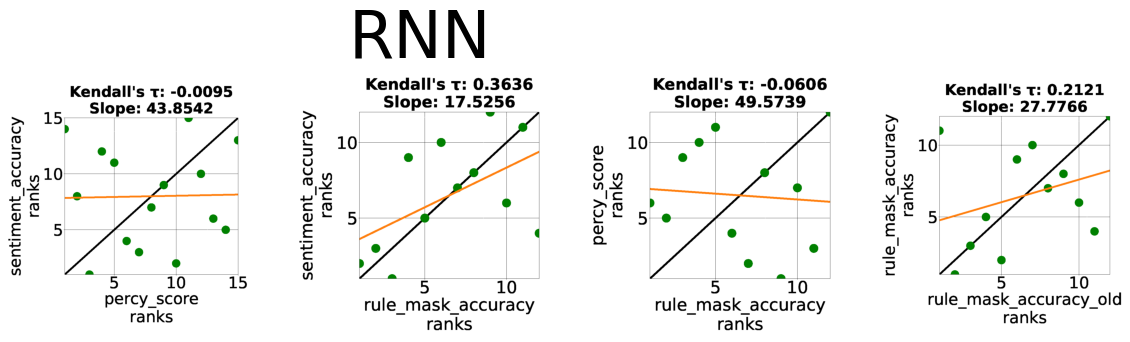

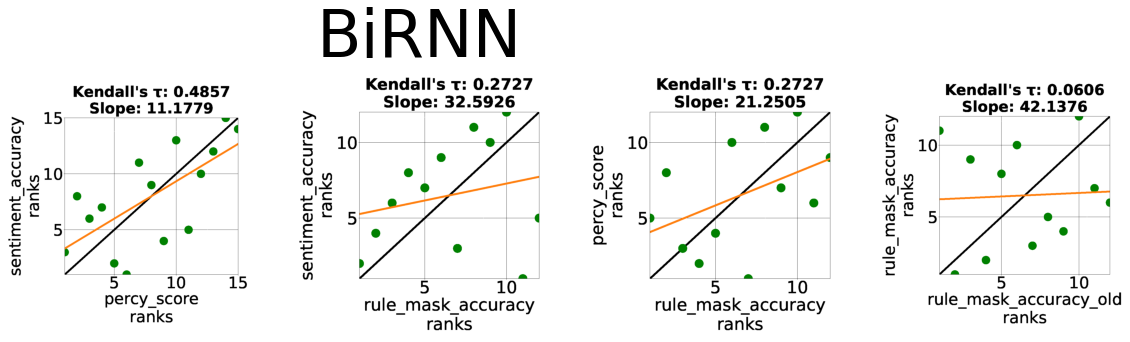

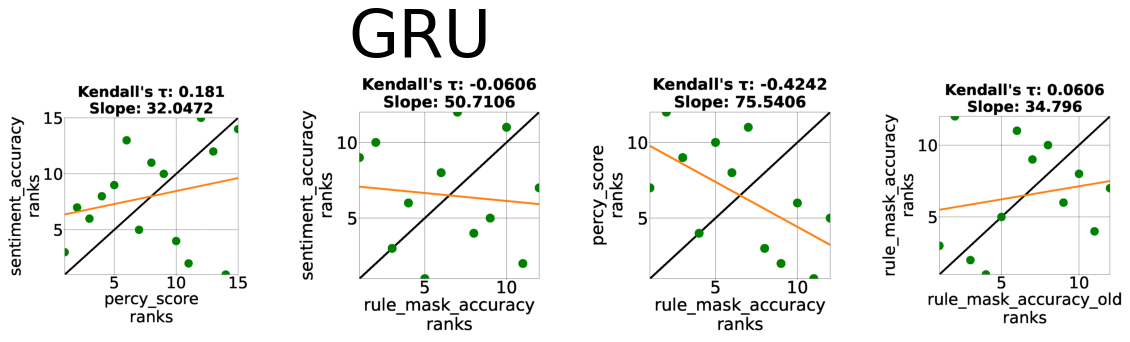

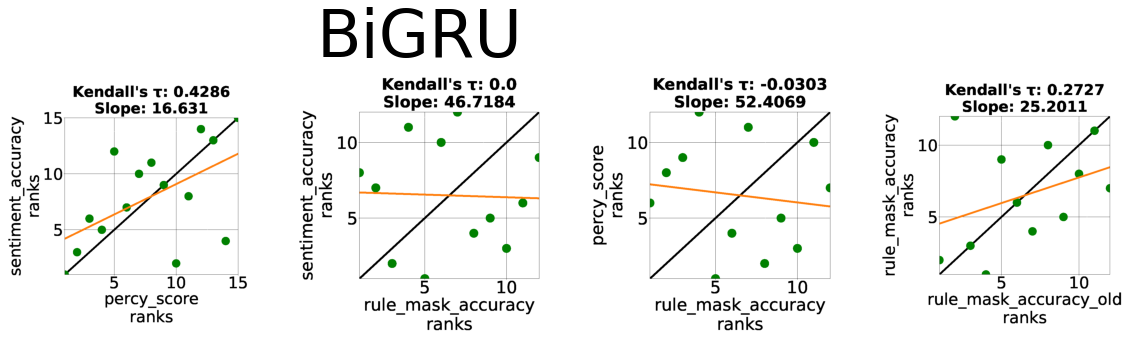

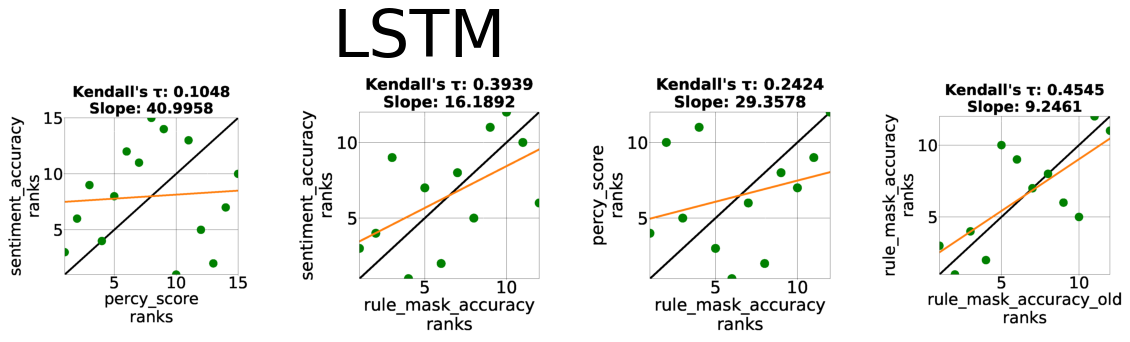

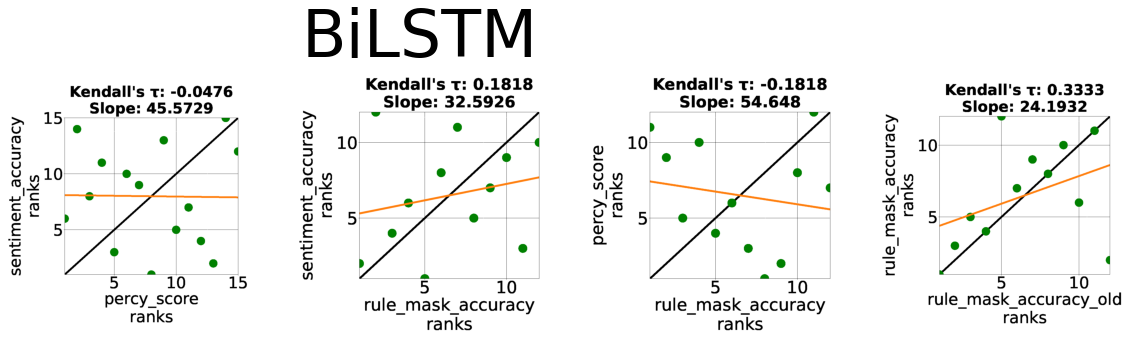

In [10]:
#### One rule ####
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# %matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 20 ,20

# read images
DNN_MODELS = ["RNN", "BiRNN", "GRU", "BiGRU", "LSTM", "BiLSTM"]
for dnn_model in DNN_MODELS:
    img_A = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_score_vs_sentiment_accuracy_ranked_corr_plots.eps")
    img_B = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_rule_mask_accuracy_vs_sentiment_accuracy_ranked_corr_plots.eps")
    img_C = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_rule_mask_accuracy_vs_percy_score_ranked_corr_plots.eps")
    img_D = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_rule_mask_accuracy_old_vs_rule_mask_accuracy_ranked_corr_plots.eps")

    # display images
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(img_A)
    ax[0].axis('off')
    ax[1].imshow(img_B)
    ax[1].axis('off')
    ax[1].set_title(dnn_model)
    ax[2].imshow(img_C)
    ax[2].axis('off')
    ax[3].imshow(img_D)
    ax[3].axis('off')

In [3]:
############ Bar-plots view of the results ############

# models = ["RNN", "BiRNN", "GRU", "BiGRU", "LSTM", "BiLSTM"]
# clrs = ["darkturquoise", "limegreen", "yellow", "lightcoral", "orange", "violet"]
# #["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey", "darkturquoise", "olive"]

# params = {'axes.labelsize': 30,
#             'axes.titlesize': 30,
#             'xtick.labelsize': 30,
#             'ytick.labelsize': 30,
#             'axes.titlepad': 12,
#             'axes.axisbelow': True,
#             'text.usetex': False,
#             'text.latex.preamble': r'\usepackage{amsmath}\usepackage{type1cm}'}
# plt.rcParams.update(params)
# fig_acc, axs = plt.subplots(6, 1, figsize=(20, 15))

# # Bar Plots
# for ind, (ax, model) in enumerate(zip(axs, models)):
    
#     ax.yaxis.grid(True)
#     ax.set_title(model, x=0.06, y=0.75, fontweight='bold')
    
#     if SHOW_RESULTS == "accuracy" or SHOW_RESULTS == "percy":
#         labels = ["Base", "IKD", "CWE", "RNN\nmask", "BiRNN\nmask", "GRU\nmask", "BiGRU\nmask", "LSTM\nmask", "BiLSTM\nmask"]
#     elif SHOW_RESULTS == "rule_mask" or SHOW_RESULTS == "contrast":
#         labels = ["RNN\nmask", "BiRNN\nmask", "GRU\nmask", "BiGRU\nmask", "LSTM\nmask", "BiLSTM\nmask"]
    
#     width = 0.9
#     x_coordinates = [index for index, value in enumerate(labels)]
    
#     colors = iter([clrs[ind]]*(len(labels)))
    
#     rnn = globals()[model]
    
#     for index, _ in enumerate(labels):
#         x_coordinate = x_coordinates[index]
#         mean = rnn[index]
#         max_val_index = rnn.index(max(rnn))
#         stat_similar_val_indices = []
#         for i, val in enumerate(rnn):
#             if max(rnn)-val < 0.03 and max(rnn)-val != 0.0:
#                 stat_similar_val_indices.append(i)
#         color = next(colors)
#         bars = ax.bar(x_coordinate, mean, width, edgecolor = 'black', linewidth = 1, color=color)
#     #     error_bars = ax.errorbar(x_coordinate, mean, yerr=std_dev, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
#         for rect in bars:
#             height = rect.get_height()
#             if index == max_val_index:
#                 ax.text(x=rect.get_x() + rect.get_width() / 2, y=height-0.06, s="{}".format(height), ha='center', fontsize='30', rotation=0, weight='bold')
# #             elif index in stat_similar_val_indices:
# #                 value = str(height)
# # #                 print(value)
# #                 ax.text(x=rect.get_x() + rect.get_width() / 2, y=height+0.02, s=r'$\underline{'+value+'}$', ha='center', fontsize='30', rotation=0, usetex=True)
#             else:
#                 ax.text(x=rect.get_x() + rect.get_width() / 2, y=height-0.06, s="{}".format(height), ha='center', fontsize='30', rotation=0)

#     #     ax.plot(correct_means, '-o', color='black', linewidth=3)
#     if model == "GRU":
#         if SHOW_RESULTS == "percy":
#             ax.set_ylabel('PERCY scores', fontweight='bold')
#             ax.yaxis.set_label_coords(-0.06, -0.4)
#         elif SHOW_RESULTS == "accuracy":
#             ax.set_ylabel('Accuracy', fontweight='bold')
#             ax.yaxis.set_label_coords(-0.06, -0.4)
#         elif SHOW_RESULTS == "rule_mask":
#             ax.set_ylabel('Rule-Mask accuracy', fontweight='bold')
#             ax.yaxis.set_label_coords(-0.06, -0.4)
#         elif SHOW_RESULTS == "contrast":
#             ax.set_ylabel('Contrast accuracy', fontweight='bold')
#             ax.yaxis.set_label_coords(-0.06, -0.4)
#     ax.set_xticks(x_coordinates)
#     ax.set_xticks(x_coordinates)
#     ax.set_xticks(x_coordinates)
#     if model == "BiLSTM":
#         ax.set_xticklabels(labels, rotation=0, ha="center")
#     ax.set_xlim(-1, len(labels))
#     ax.set_ylim(0.01, 1.0)
    
#     if model != "BiLSTM":
#         ax.xaxis.set_visible(False)
#         ax.spines['bottom'].set_visible(False)

#     plt.tight_layout()
#     plt.subplots_adjust(left=0.2, bottom=None, right=None, top=None, wspace=None, hspace=0)

# # # Save fig
# # if not os.path.exists("analysis/WISE2023/"):
# #     os.makedirs("analysis/WISE2023/")
# # plt.savefig('analysis/WISE2023/bar_plots.eps', bbox_inches = 'tight')

# # Display fig
# plt.show()

In [ ]:
############ Convergence plots ############

In [29]:
# Generate the Latex code for tabular view of the results => It is very handy and easy to put results in the draft without any errors
from scipy.stats import ttest_ind
import numpy as np

classifiers = [RNN, BiRNN, GRU, BiGRU, LSTM, BiLSTM]
distributions = [RNN_distributions, BiRNN_distributions, GRU_distributions, BiGRU_distributions, LSTM_distributions, BiLSTM_distributions]

columns = []
for index, classifier in enumerate(classifiers):
    distribution = distributions[index]
    column = []
    highest_value = max(classifier)
    highest_value_index = classifier.index(highest_value)
    highest_value_dist = distribution[highest_value_index]
    pvals_to_highest_val = []
    for dist in distribution:
        ttest, pval = ttest_ind(highest_value_dist, dist)
        pvals_to_highest_val.append(pval)
    for index, value in enumerate(classifier):
        pval = pvals_to_highest_val[index]
        if pval == 1:
            val = "&"+r"\textbf{"+str(value)+"}"
            column.append(val)
        elif pval > 0.05 and pval!=1:
            val = "&"+r"\underline{"+str(value)+"}"
            column.append(val)
        else:
            val = "&"+str(value)
            column.append(val)
    columns.append(column)

columns_np = np.array(columns)
columns_np_transpose = columns_np.transpose()

for col in columns_np_transpose:
    print(col)
    
####The output should be as follows####
# \hline
#     \textit{Vanilla Classifiers} &0.879 &0.903 &\underline{0.952} &\textbf{0.953}
#     &0.936 &0.934\\
# \hline
#     \textit{Baseline Classifiers} & & & & & &\\
#         IKD &0.885 &0.882 &0.940 &0.937 &0.935 &0.934\\
#         CWE &\textbf{0.932} &0.882 &\textbf{0.957} &\underline{0.952} &\textbf{0.946} &\textbf{0.943}\\
# \hline
#     \textit{RMM Configurations} & & & & & &\\
#         RNN-mask &0.888 &0.897 &0.949 &0.944 &0.930 &0.935\\
#         BiRNN-mask &0.897 &\underline{0.913} &0.950 &\underline{0.949} &0.936 &\underline{0.940}\\
#         GRU-mask &0.890 &\textbf{0.915} &\underline{0.953} &\underline{0.951} &\underline{0.941} &\underline{0.937}\\
#         BiGRU-mask &0.896 &\underline{0.914} &\underline{0.953} &0.942 &\underline{0.941} &\underline{0.938}\\
#         LSTM-mask &0.884 &0.905 &\underline{0.951} &\underline{0.950} &\underline{0.942} &\underline{0.938}\\
#         BiLSTM-mask &0.901 &\underline{0.915} &\underline{0.952} &\textbf{0.953} &\underline{0.942} &\underline{0.941}\\
# \hline

['&0.879' '&0.903' '&\\underline{0.952}' '&\\textbf{0.953}' '&0.936'
 '&0.934']
['&0.885' '&0.882' '&0.94' '&0.937' '&0.935' '&0.934']
['&\\textbf{0.932}' '&0.882' '&\\textbf{0.957}' '&\\underline{0.952}'
 '&\\textbf{0.946}' '&\\textbf{0.943}']
['&0.888' '&0.897' '&0.949' '&0.944' '&0.93' '&0.935']
['&0.897' '&\\underline{0.913}' '&0.95' '&\\underline{0.949}' '&0.936'
 '&\\underline{0.94}']
['&0.89' '&\\textbf{0.915}' '&\\underline{0.953}' '&\\underline{0.951}'
 '&\\underline{0.941}' '&\\underline{0.937}']
['&0.896' '&\\underline{0.914}' '&\\underline{0.953}' '&0.942'
 '&\\underline{0.941}' '&\\underline{0.938}']
['&0.884' '&0.905' '&\\underline{0.951}' '&\\underline{0.95}'
 '&\\underline{0.942}' '&\\underline{0.938}']
['&0.901' '&\\underline{0.915}' '&\\underline{0.952}' '&\\textbf{0.953}'
 '&\\underline{0.942}' '&\\underline{0.941}']


In [26]:
##### Calculating the rule-mask accuracy on one-rule subset #####
with open("mask_model/assets/results/bigru_bigru_mask_model.pickle", 'rb') as handle:
    results_mask = pickle.load(handle)
    results_mask = pd.DataFrame(results_mask)

results_mask_one_rule_contrast = results_mask.loc[(results_mask["rule_label"]!=0)&(results_mask["contrast"]==1)].reset_index(drop=True)
results_mask_one_rule_no_contrast = results_mask.loc[(results_mask["rule_label"]!=0)&(results_mask["contrast"]==0)].reset_index(drop=True)

#contrast subset
contrast_scores = []
for index, _ in enumerate(results_mask_one_rule_contrast.iterrows()):
    if results_mask_one_rule_contrast["rule_label"][index] == 1:
        tokenized_sentence = results_mask_one_rule_contrast["sentence"][index].split()
        but_index = tokenized_sentence.index("but")
        rule_mask_pred = results_mask_one_rule_contrast["rule_label_mask_prediction_output"][index]
        rule_mask_ground_truth = results_mask_one_rule_contrast["rule_label_mask"][index]
        assert len(rule_mask_pred) == len(rule_mask_ground_truth)
        for token_index, _ in enumerate(rule_mask_pred):
            if token_index <= but_index:
                if rule_mask_pred[token_index] == rule_mask_ground_truth[token_index]:
                    contrast_scores.append(1)
                elif rule_mask_pred[token_index] != rule_mask_ground_truth[token_index]:
                    contrast_scores.append(-1)
            elif token_index > but_index:
                if rule_mask_pred[token_index] == rule_mask_ground_truth[token_index]:
                    contrast_scores.append(1)
                elif rule_mask_pred[token_index] != rule_mask_ground_truth[token_index]:
                    contrast_scores.append(-2)
    elif results_mask_one_rule_contrast["rule_label"][index] == 2:
        tokenized_sentence = results_mask_one_rule_contrast["sentence"][index].split()
        but_index = tokenized_sentence.index("yet")
        rule_mask_pred = results_mask_one_rule_contrast["rule_label_mask_prediction_output"][index]
        rule_mask_ground_truth = results_mask_one_rule_contrast["rule_label_mask"][index]
        assert len(rule_mask_pred) == len(rule_mask_ground_truth)
        for token_index, _ in enumerate(rule_mask_pred):
            if token_index <= but_index:
                if rule_mask_pred[token_index] == rule_mask_ground_truth[token_index]:
                    contrast_scores.append(1)
                elif rule_mask_pred[token_index] != rule_mask_ground_truth[token_index]:
                    contrast_scores.append(-1)
            elif token_index > but_index:
                if rule_mask_pred[token_index] == rule_mask_ground_truth[token_index]:
                    contrast_scores.append(1)
                elif rule_mask_pred[token_index] != rule_mask_ground_truth[token_index]:
                    contrast_scores.append(-2)
    elif results_mask_one_rule_contrast["rule_label"][index] == 3:
        tokenized_sentence = results_mask_one_rule_contrast["sentence"][index].split()
        but_index = tokenized_sentence.index("though")
        rule_mask_pred = results_mask_one_rule_contrast["rule_label_mask_prediction_output"][index]
        rule_mask_ground_truth = results_mask_one_rule_contrast["rule_label_mask"][index]
        assert len(rule_mask_pred) == len(rule_mask_ground_truth)
        for token_index, _ in enumerate(rule_mask_pred):
            if token_index <= but_index:
                if rule_mask_pred[token_index] == rule_mask_ground_truth[token_index]:
                    contrast_scores.append(1)
                elif rule_mask_pred[token_index] != rule_mask_ground_truth[token_index]:
                    contrast_scores.append(-2)
            elif token_index > but_index:
                if rule_mask_pred[token_index] == rule_mask_ground_truth[token_index]:
                    contrast_scores.append(1)
                elif rule_mask_pred[token_index] != rule_mask_ground_truth[token_index]:
                    contrast_scores.append(-1)
    elif results_mask_one_rule_contrast["rule_label"][index] == 4:
        tokenized_sentence = results_mask_one_rule_contrast["sentence"][index].split()
        but_index = tokenized_sentence.index("while")
        rule_mask_pred = results_mask_one_rule_contrast["rule_label_mask_prediction_output"][index]
        rule_mask_ground_truth = results_mask_one_rule_contrast["rule_label_mask"][index]
        assert len(rule_mask_pred) == len(rule_mask_ground_truth)
        for token_index, _ in enumerate(rule_mask_pred):
            if token_index <= but_index:
                if rule_mask_pred[token_index] == rule_mask_ground_truth[token_index]:
                    contrast_scores.append(1)
                elif rule_mask_pred[token_index] != rule_mask_ground_truth[token_index]:
                    contrast_scores.append(-2)
            elif token_index > but_index:
                if rule_mask_pred[token_index] == rule_mask_ground_truth[token_index]:
                    contrast_scores.append(1)
                elif rule_mask_pred[token_index] != rule_mask_ground_truth[token_index]:
                    contrast_scores.append(-1)
                    
#no contrast subset
no_contrast_scores = []
for index, row in enumerate(results_mask_one_rule_no_contrast.iterrows()):
    rule_mask_pred = results_mask_one_rule_no_contrast["rule_label_mask_prediction_output"][index]
    rule_mask_ground_truth = results_mask_one_rule_no_contrast["rule_label_mask"][index]
    assert len(rule_mask_pred) == len(rule_mask_ground_truth)
    for token_index, _ in enumerate(rule_mask_pred):
        if rule_mask_pred[token_index] == rule_mask_ground_truth[token_index]:
            no_contrast_scores.append(1)
        elif rule_mask_pred[token_index] != rule_mask_ground_truth[token_index]:
            no_contrast_scores.append(-1)
            
one_rule_corrects = contrast_scores + no_contrast_scores

0.6606063865461148
